In [1]:
import sys, os

import numpy as np

import scipy
from scipy import optimize


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
current_palette = sns.color_palette()

In [106]:
from thurner_model import NoiseTrader, Fund, find_equilibrium 
import plotting

Here, I model the fund as a learning agent, which is able to adjust its demand function over time

In [174]:
class LearningFund(Fund):
    """
    Description: Base Class is Fund, defined in thurner_model.py
    The Learning Fund learns its demand function via reinforcement learning
    """
    
    def __init__(self):
        # The learning fund does not need a beta
        self.cash = self.initial_wealth
        self.shares = 0 
        self.activation_delay = 0
    
    def get_demand(self, p_t): # this needs to be a function of p_t for the market clearing to work
        """
        Oh look, a docstring
        """ 
        # the mispricing signal m_t is the difference
        # between the fundamental value V and the price p_t
        m_t = V - p_t
        m_critical = self.lambda_max / self.beta        
        
        # if the mispricing signal m_t is positive and 
        # m_critical is not reached, yet
        if 0 < m_t and m_t < m_critical:
            return self.beta * m_t * self.get_wealth(p_t) / p_t 
        # if m_critical is reached, fund leverages 
        # to the maximum 
        elif m_t >= m_critical:
            return self.lambda_max * self.get_wealth(p_t) / p_t

        # if m_t < 0, ie the mispricing signal, is negative,
        # demand is zero
        else:
            return 0

In [176]:
class Env:
    """
    Docstring
    """
    # Define our fundamental value V and asset-supply N
    V = 1.
    N = 1000.
    
    initial_price = 1.
    
    # Define noise trader (uses the NoiseTrader Class defined in thurner_model.py)
    roh_nt = 0.99
    sigma_nt = 0.035
    noise_trader = NoiseTrader(roh_nt, sigma_nt, V, N)
    initial_nt_spending = V*N
    
    def __init__(self):
        # tracks trader spending, this is not observed by the fund
        # therefore it is not in the environment's state
        
        self.p_t = self.initial_price
        self.xi_t = self.initial_nt_spending
        
        
    # when resetting the environment, we set its state back to the initial state
    def reset(self):
        self.p_t = self.initial_price
        self.xi_t = self.initial_nt_spending

    def step(self, funds):
        """Finds equilibrium, and updates environment parameters""" 
        
        # 1. Find the new price for the timestep
        self.xi_t = self.noise_trader.cash_spending(self.xi_t)

        self.p_t = find_equilibrium(self.xi_t, funds)
    
        # 2. update the holdings of all the funds (wealth, shares and cash)
        current_wealth = []
        for fund in funds:
            fund.update_holdings(self.p_t)
            fund.check_and_make_bankrupt(self.p_t)
            #fund.processInflows(oldprice, newprice)
            current_wealth.append(fund.get_wealth(self.p_t))
        
        return current_wealth

In [177]:
[f.beta for f in funds]

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

In [191]:
prices = []
funds_wealth = []

# Create the environment


number_of_funds = 10
funds = [Fund((i+1)*5) for i in range(number_of_funds)]

# set initial situation
env = Env()
env.reset()
print("Start: \tPrice: {}\tSpending: {}".format(env.p_t, env.xi_t))

for i in range(10000):
    #take a step in the environment
    current_wealth = env.step(funds)
    
    # record the current price and wealth of all funds
    prices.append(env.p_t)
    funds_wealth.append(current_wealth)
    

Start: 	Price: 1.0	Spending: 1000.0


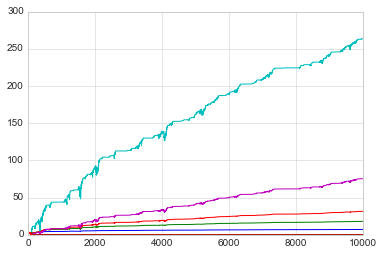

In [192]:
plt.plot(funds_wealth);

In [13]:

for i_episode in range(num_episodes):
    state = initial_state
    episode = []
    # One step in the environment
        for t in itertools.count():
            demand = 

array([1, 2, 2, 0, 0])

# From Denny Britz

In [ ]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.mu = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            self.mu = tf.squeeze(self.mu)
            
            self.sigma = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            self.sigma = tf.squeeze(self.sigma)
            self.sigma = tf.nn.softplus(self.sigma) + 1e-5
            self.normal_dist = tf.contrib.distributions.Normal(self.mu, self.sigma)
            self.action = self.normal_dist._sample_n(1)
            self.action = tf.clip_by_value(self.action, env.action_space.low[0], env.action_space.high[0])

            # Loss and train op
            self.loss = -self.normal_dist.log_prob(self.action) * self.target
            # Add cross entropy cost to encourage exploration
            self.loss -= 1e-1 * self.normal_dist.entropy()
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.action, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [ ]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [ ]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    initial_price = 1
    initial_fund_wealth = 2
    initial_cash = initial_wealth
    initial_shares = 0 
    initial_activation_delay = 0 
    
    initial_state = np.array([initial_price, initial_fund_wealth, initial_cash, initial_shares, initial_activation_delay])
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        # this is our initial state
        state = initial_state
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # env.render()
            
            # Take a step
            demand = estimator_policy.predict(state)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats

In [ ]:
# This works
tf.reset_default_graph()

global_step = tf.train.get_global_step()
policy_estimator = PolicyEstimator(learning_rate=0.001)
value_estimator = ValueEstimator(learning_rate=0.1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Note, due to randomness in the policy the number of episodes you need varies
    # TODO: Sometimes the algorithm gets stuck, I'm not sure what exactly is happening there.
    stats = actor_critic(env, policy_estimator, value_estimator, 50, discount_factor=0.95)